In [1]:
import utils
import models
import numpy as np
import torch
import configs
import pgm_explainer as pe
from scipy.special import softmax
import pandas as pd
from pgmpy.estimators.CITests import chi_square
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination
import pandas as pd
import argparse
from tqdm import tqdm

def arg_parse():
    parser = argparse.ArgumentParser(description="Explainer arguments.")

    parser.add_argument(
            "--bmname", dest="bmname", help="Name of the benchmark dataset"
        )
    parser.add_argument("--dataset", dest="dataset", help="Input dataset.")
    parser.add_argument("--ckptdir", dest="ckptdir", help="Model checkpoint directory")
    parser.add_argument(
            "--gpu",
            dest="gpu",
            action="store_const",
            const=True,
            default=False,
            help="whether to use GPU.",
        )
    parser.add_argument(
            "--node-start", dest="node_start", type=int, help="Index of starting node."
        )
    parser.add_argument(
            "--node-end", dest="node_end", type=int, help="Index of ending node."
        )
    parser.add_argument(
            "--num-perturb-samples", dest="num_perturb_samples", type=int, help="Number of perturbed sample using to generate explanations."
        )
    parser.add_argument(
            "--top-node", dest="top_node", type=int, help="Number of nodes in explanation."
        )
    parser.add_argument(
            "--epochs", dest="num_epochs", type=int, help="Number of epochs to train."
        )
    parser.add_argument(
            "--hidden-dim", dest="hidden_dim", type=int, help="Hidden dimension"
        )
    parser.add_argument(
            "--output-dim", dest="output_dim", type=int, help="Output dimension"
        )
    parser.add_argument(
            "--num-gc-layers",
            dest="num_gc_layers",
            type=int,
            help="Number of graph convolution layers before each pooling",
        )
    parser.add_argument(
            "--bn",
            dest="bn",
            action="store_const",
            const=True,
            default=False,
            help="Whether batch normalization is used",
        )
    parser.add_argument("--dropout", dest="dropout", type=float, help="Dropout rate.")
    parser.add_argument(
            "--method", dest="method", type=str, help="Method. Possible values: base, att."
        )
    parser.add_argument(
            "--nobias",
            dest="bias",
            action="store_const",
            const=False,
            default=True,
            help="Whether to add bias. Default to True.",
        )
    
        # Explainer
   
    

    parser.set_defaults(
            ckptdir=None,
            dataset="syn1",
            opt="adam",  
            opt_scheduler="none",
            lr=0.1,
            clip=2.0,
            batch_size=20,
            num_epochs=100,
            hidden_dim=20,
            output_dim=20,
            num_gc_layers=3,
            method="base",
            dropout=0.0,
            node_start = None,
            node_end = None,
            num_perturb_samples = 100,
            top_node = None
        )
    
    return parser

d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
prog_args = arg_parse()
args= prog_args.parse_args(['--dataset','syn1','--num-perturb-samples', '900','--top-node', '3'])

In [3]:
# Load model
A, X = utils.load_XA(args.dataset, datadir = "../Generate_XA_Data/XAL")
L = utils.load_labels(args.dataset, datadir = "../Generate_XA_Data/XAL")
print("A type: ", type(A))
num_classes = max(L) + 1
input_dim = X.shape[1]
num_nodes = X.shape[0]
ckpt = utils.load_ckpt(args)

print("input dim: ", input_dim, "; num classes: ", num_classes)
    
model = models.GcnEncoderNode(
        input_dim=input_dim,
        hidden_dim=args.hidden_dim,
        embedding_dim=args.output_dim,
        label_dim=num_classes,
        num_layers=args.num_gc_layers,
        bn=args.bn,
        args=args,
        )
model.load_state_dict(ckpt["model_state"]) 
pred = ckpt["save_data"]["pred"]

A type:  <class 'numpy.ndarray'>
loading model
../Train_GNN_model/ckpt\syn1.pth.tar
=> loading checkpoint '../Train_GNN_model/ckpt\syn1.pth.tar'
input dim:  10 ; num classes:  4


In [4]:
import random
random.seed(21)

In [5]:
# Range of node to explain in this dataset is from 300 to 700
nodes_to_explain = list(range(400,700,5)) 

In [6]:
# Construct the explainer
explainer = pe.Node_Explainer(model, A, X, pred, 3)

Explainer settings
\ A dim:  (700, 700)
\ X dim:  (700, 10)
\ Number of layers:  3
\ Perturbation mode:  0
\ Print result:  1


In [7]:
import networkx as nx
import pylab as plt

def pgm_draw_nx(pgm_explanation):
    print("Draw pgm explaination using networkx")
    nx.draw(pgm_explanation, with_labels=True)
    plt.show()

def PGM_construct(pgm_explanation, target_name):
    loc = [(0, 0), (-5, -5), (5, -5), (5, 5), (-5,5)]
    pos = dict(zip(pgm_explanation.nodes(), loc))
    color_dict = dict(zip(range(pred.shape[2]), ['y','b','m','r']))
    color = [color_dict[ np.argmax(pred[0,int(node),:])] for node in pgm_explanation.nodes()]
    name_dict = [r'$A$',r'$B$',r'$C$',r'$D$',r'$E$']
    name = dict(zip(pgm_explanation.nodes(), name_dict))

    # gt_graph = nx.Graph()
    # gt_graph.add_nodes_from(pos.keys(), size=50)
    # edges_list = [('300', '301'),('301', '302'),('302', '300'),('303', '300'),('304', '300')]
    # gt_graph.add_edges_from(edges_list)

    # print("Ground truth explaination of node ", name[target_name])
    # figure1, ax1 = plt.subplots(figsize = (4,4))
    # ax1.axis('off')
    # nx.draw_networkx_nodes(gt_graph,pos,node_size=400,node_color= color)
    # nx.draw_networkx_edges(gt_graph,pos,
    #                     edgelist= edges_list,
    #                     width=2.0,alpha=1)
    # nx.draw_networkx_labels(gt_graph,pos,name,font_size=18, font_family = 'serif', font_weight = 'normal',
    #                         font_color = 'w')

    # # filename = 'view/motif_' + str(explained_node)+ '.jpg' 
    # # figure1.savefig(filename, dpi=90, bbox_inches='tight')

    print("PGM explaination of node ", name[target_name])

    figure2, ax = plt.subplots(figsize = (4,4))
    ax.axis('off')
    nx.draw_networkx_nodes(pgm_explanation,pos,node_size=400,node_color= color)
    nx.draw_networkx_edges(pgm_explanation,pos,
                        edgelist= pgm_explanation.edges,
                        connectionstyle='arc3, rad = 0.2',
                        width=2.0,alpha=0.8)
    nx.draw_networkx_labels(pgm_explanation,pos,name,font_size=18, font_family = 'serif', font_color = 'w')
    figure2.show()

    # filename = 'view/pgm_' + str(explained_node)+ '.jpg' 
    # figure2.savefig(filename, dpi=90, bbox_inches='tight')



In [8]:
# target = nodes_to_explain[0]

# print(f"--------------------------- Node {target} ---------------------------")
# # Explaining the target node
# subnodes, data, stats = explainer.explain(target, num_samples = 900, top_node = 3, pred_threshold = 0.2)
# # Markov Blanket of target node
# print("MK-blanket of target node:", subnodes)

# # Generating the Probabilistic Graph
# print("Generate the PGM")
# pgm_explanation = explainer.pgm_generate(target, data, stats, subnodes)
# print("PGM Nodes: ", pgm_explanation.nodes())
# print("PGM Edges: ", pgm_explanation.edges())

# # Conversion of target names for preventing type mismatch
# print("The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience")
# target_name = str(target)
# explaining_nodes = [node for node in pgm_explanation.nodes() if node != target_name]

# # Computing marginal probability of target prediction with no observation
# print("Compute marginal probability of the target prediction with no observation")
# marginal_prob = explainer.pgm_conditional_prob(target_name, pgm_explanation, [])
# print(marginal_prob)

# # Computing other probabilities
# target_label = np.argmax(pred[0,target])
# print("Target's label is: ", target_label)
# for num_of_evidence in range(len(explaining_nodes)):
#     cond_prob = explainer.pgm_conditional_prob(target_name, pgm_explanation, explaining_nodes[0:num_of_evidence+1])
#     print("Probability that the target's label is {} given {} is {}".format(target_label,
#                                                                             explaining_nodes[0:num_of_evidence+1],
#                                                                         cond_prob))


# # Drawing pgm explanation
# pgm_draw_nx(pgm_explanation)
# PGM_construct(pgm_explanation, target_name)

In [14]:
# Functions to analyze the graph properties
def betweeness_centrality_single_sink(graph,node_to_explain, v):
    
    bc = 0
    diameter = nx.diameter(graph)
    nodes = list(graph.nodes())
    for i in tqdm(range(len(nodes))):
        paths_with_v = 0
        paths = 0
        if nodes[i]!=node_to_explain and nodes[i]!=v:
            # print(f"Centrality of {v} chosen node {i}")
            if nx.has_path(graph,nodes[i],node_to_explain):
                # Find all paths between i and the node_to_explain
                all_paths = nx.all_simple_paths(graph,nodes[i],node_to_explain,diameter)
                # print("All paths obtained")

                # Find the paths containing v
                for path in all_paths:
                    # print("loop entered")
                    # print(paths)
                    paths += 1
                    if v in path:
                        paths_with_v += 1

                # Add this to bc
                bc += paths_with_v/paths
    
    return bc

def normalize(A):
    scale_factor = A.max() - A.min()
    B = np.ones_like(A)*A.min()

    A = (A - B)/scale_factor
    return A

def centrality(G, stats,node_to_explain,variation=1,p_threshold=0.05):
    
    # # Obtain the importance score for all nodes
    # bc = {}
    # for v in list(G.nodes()):
    #     print(f"Calculating centrality for {v}")
    #     if v!=node_to_explain:
    #         bc.update({v : betweeness_centrality_single_sink(G,node_to_explain, v)})
    
    # bc.update({node_to_explain: 1})
    # bc ={}

    if variation==1:
        bc = nx.betweenness_centrality(G)
        ebc = nx.edge_betweenness_centrality(G)
    elif variation==2:
        sources = [node_to_explain]
        targets = [v for v in list(G.nodes()) if v!=node_to_explain]
        bc = nx.betweenness_centrality_subset(G,sources,targets)
        ebc = nx.edge_betweenness_centrality_subset(G,sources,targets)

    # Edge coherence
    A = np.zeros((len(G),len(G)))
    B = np.zeros((len(G),len(G)))
    nodes = list(G.nodes())
    
    for i in range(len(G)):
        for j in range(i):
            # Get edge mask
            # Idea: imp(edge) = avg(importance of its endvertices)
            edge_imp_val = 0.5*(stats.get(nodes[i]) + stats.get(nodes[j]))
            A[i][j] = A[j][i] = edge_imp_val

            # Edge centrality
            if (nodes[j],nodes[i]) in list(ebc.keys()):
                B[i][j] = B[j][i] = ebc[(nodes[j],nodes[i])]
    
    A1 = normalize(A)
    B1 = normalize(B)
    
    if(np.array_equal(A1,B1) == False):
        coh_edge = 1/(np.linalg.norm(A1 - B1,2))**2
    else:
        coh_edge = 1
    
    
    # Node coherence
    # Get the two vectors we have to compare for coherence calculation
    # We are fixing the values as 0 for the nodes not in "nodes_to_consider"
    A2 = []
    B2 = []
    for i in list(G.nodes()):
        A2.append(bc.get(i))
        B2.append(1 - (stats.get(i)))

    A2 = normalize(np.array(A2))
    B2 = normalize(np.array(B2))

    # Calculating coherence
    if(np.array_equal(A2,B2) == False):
        coh_node = 1/(np.linalg.norm(A2 - B2,2))**2
    else:
        coh_node = 1
    
    return coh_node, coh_edge

def graph_prop(graph, stats, target, p_threshold,variation=1):
    v = graph.number_of_nodes()
    e = graph.number_of_edges()
    avg_degree = float('%.3f'%(2*e/v))
    diameter = nx.diameter(graph)
    sparsity = float('%.3f'%(2*e/(v*(v-1))))
    coh_node, coh_edge = centrality(graph,stats, target, variation, p_threshold)

    return [v,e,avg_degree,diameter,sparsity,coh_node, coh_edge]

In [15]:
# Check the node mask obtained
# "stats" has the n-hop neighbors of the target node and the corresponding p-values
# The dependent neighbors are chosen based on comparing the p-value to a certain threshold
# For this reason we use the p-values as an indicator of importance of the node
# We define node_importance_by_exp = (1-p)

graph_data1 = []
variation = 1

# Explaining each target node
for target in nodes_to_explain:
    # Explaining the target node
    p_threshold = 0.05  # Default threshold for p-value according to statistics

    # We set top_node as None since we want to check how compact the explanations are without restricting its size
    _, _, stats = explainer.explain(target, num_samples = 900, p_threshold=p_threshold, pred_threshold = 0.2)

    # Original network
    G = nx.from_numpy_array(explainer.A)
    # Considered neighbors
    nbors = list(stats.keys())
    # nodes_to_consider = []
    # # Masking the nodes
    # for v in nbors:
    #     if stats.get(v) < p_threshold:
    #         nodes_to_consider.append(v)

    # Vertex induced subgraph that acts as the explanation
    exp_subgraph = nx.induced_subgraph(G, nbors)

    # All properties obtained
    graph_data1.append(graph_prop(exp_subgraph,stats, target, p_threshold,variation))

# Convert the above data into a data frame
df1 = pd.DataFrame(graph_data1, columns=["Order","Size","Average Degree","Diameter","Sparsity","Node Coherence","Edge Coherence"])

df1.describe()

Explaining node: 400
Explaining node: 405
Explaining node: 410
Explaining node: 415
Explaining node: 420
Explaining node: 425
Explaining node: 430
Explaining node: 435
Explaining node: 440
Explaining node: 445
Explaining node: 450
Explaining node: 455
Explaining node: 460
Explaining node: 465
Explaining node: 470
Explaining node: 475
Explaining node: 480
Explaining node: 485
Explaining node: 490
Explaining node: 495
Explaining node: 500
Explaining node: 505
Explaining node: 510
Explaining node: 515
Explaining node: 520
Explaining node: 525
Explaining node: 530
Explaining node: 535
Explaining node: 540
Explaining node: 545
Explaining node: 550
Explaining node: 555
Explaining node: 560
Explaining node: 565
Explaining node: 570
Explaining node: 575
Explaining node: 580
Explaining node: 585
Explaining node: 590
Explaining node: 595
Explaining node: 600
Explaining node: 605
Explaining node: 610
Explaining node: 615
Explaining node: 620
Explaining node: 625
Explaining node: 630
Explaining no

,Order,Size,Average Degree,Diameter,Sparsity,Node Coherence,Edge Coherence
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,120.133333,416.483333,6.654117,5.166667,0.058767,0.079089,0.000148
std,36.649724,180.849454,1.020604,0.375823,0.010257,0.020094,0.000108
min,58.000000,137.000000,4.515000,5.000000,0.040000,0.038605,0.000032
25%,86.750000,263.500000,5.933250,5.000000,0.050000,0.061345,0.000073
50%,121.000000,401.000000,6.715500,5.000000,0.058500,0.081945,0.000102
75%,144.000000,542.250000,7.465500,5.000000,0.065250,0.090472,0.000214
max,208.000000,864.000000,8.368000,6.000000,0.083000,0.122077,0.000508


In [16]:
# Normalize the Coherence
coh_node = list(df1["Node Coherence"])
coh_node_norm = [float(i)/max(coh_node) for i in coh_node]

coh_edge = list(df1["Edge Coherence"])
coh_edge_norm = [float(i)/max(coh_edge) for i in coh_edge]

df1 = df1.replace(coh_node, coh_node_norm)
df1 = df1.replace(coh_edge, coh_edge_norm)
df1.describe()

,Order,Size,Average Degree,Diameter,Sparsity,Node Coherence,Edge Coherence
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,120.133333,416.483333,6.654117,5.166667,0.058767,0.647865,0.292032
std,36.649724,180.849454,1.020604,0.375823,0.010257,0.164604,0.211618
min,58.000000,137.000000,4.515000,5.000000,0.040000,0.316239,0.063800
25%,86.750000,263.500000,5.933250,5.000000,0.050000,0.502514,0.142675
50%,121.000000,401.000000,6.715500,5.000000,0.058500,0.671260,0.200046
75%,144.000000,542.250000,7.465500,5.000000,0.065250,0.741104,0.421939
max,208.000000,864.000000,8.368000,6.000000,0.083000,1.000000,1.000000


In [17]:
# Check the node mask obtained
# "stats" has the n-hop neighbors of the target node and the corresponding p-values
# The dependent neighbors are chosen based on comparing the p-value to a certain threshold
# For this reason we use the p-values as an indicator of importance of the node
# We define node_importance_by_exp = (1-p)

graph_data2 = []
variation = 2

# Explaining each target node
for target in nodes_to_explain:
    # Explaining the target node
    p_threshold = 0.05  # Default threshold for p-value according to statistics

    # We set top_node as None since we want to check how compact the explanations are without restricting its size
    _, _, stats = explainer.explain(target, num_samples = 900, p_threshold=p_threshold, pred_threshold = 0.2)

    # Original network
    G = nx.from_numpy_array(explainer.A)
    # Considered neighbors
    nbors = list(stats.keys())
    # nodes_to_consider = []
    # # Masking the nodes
    # for v in nbors:
    #     if stats.get(v) < p_threshold:
    #         nodes_to_consider.append(v)

    # Vertex induced subgraph that acts as the explanation
    exp_subgraph = nx.induced_subgraph(G, nbors)

    # All properties obtained
    graph_data2.append(graph_prop(exp_subgraph,stats, target, p_threshold,variation))

Explaining node: 400
Explaining node: 405
Explaining node: 410
Explaining node: 415
Explaining node: 420
Explaining node: 425
Explaining node: 430
Explaining node: 435
Explaining node: 440
Explaining node: 445
Explaining node: 450
Explaining node: 455
Explaining node: 460
Explaining node: 465
Explaining node: 470
Explaining node: 475
Explaining node: 480
Explaining node: 485
Explaining node: 490
Explaining node: 495
Explaining node: 500
Explaining node: 505
Explaining node: 510
Explaining node: 515
Explaining node: 520
Explaining node: 525
Explaining node: 530
Explaining node: 535
Explaining node: 540
Explaining node: 545
Explaining node: 550
Explaining node: 555
Explaining node: 560
Explaining node: 565
Explaining node: 570
Explaining node: 575
Explaining node: 580
Explaining node: 585
Explaining node: 590
Explaining node: 595
Explaining node: 600
Explaining node: 605
Explaining node: 610
Explaining node: 615
Explaining node: 620
Explaining node: 625
Explaining node: 630
Explaining no

ValueError: 6 columns passed, passed data had 7 columns

In [18]:
# Convert the above data into a data frame
df2 = pd.DataFrame(graph_data2, columns=["Order","Size","Average Degree","Diameter","Sparsity","Node Coherence","Edge Coherence"])

df2.describe()

,Order,Size,Average Degree,Diameter,Sparsity,Node Coherence,Edge Coherence
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,120.133333,416.483333,6.654117,5.166667,0.058767,0.075476,0.000148
std,36.649724,180.849454,1.020604,0.375823,0.010257,0.022147,0.000104
min,58.000000,137.000000,4.515000,5.000000,0.040000,0.018192,0.000034
25%,86.750000,263.500000,5.933250,5.000000,0.050000,0.060524,0.000072
50%,121.000000,401.000000,6.715500,5.000000,0.058500,0.076350,0.000112
75%,144.000000,542.250000,7.465500,5.000000,0.065250,0.090349,0.000204
max,208.000000,864.000000,8.368000,6.000000,0.083000,0.120927,0.000510


In [19]:
# Normalize the Coherence
coh_node = list(df2["Node Coherence"])
coh_node_norm = [float(i)/max(coh_node) for i in coh_node]

coh_edge = list(df2["Edge Coherence"])
coh_edge_norm = [float(i)/max(coh_edge) for i in coh_edge]

df2 = df2.replace(coh_node, coh_node_norm)
df2 = df2.replace(coh_edge, coh_edge_norm)
df2.describe()

,Order,Size,Average Degree,Diameter,Sparsity,Node Coherence,Edge Coherence
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,120.133333,416.483333,6.654117,5.166667,0.058767,0.624146,0.290606
std,36.649724,180.849454,1.020604,0.375823,0.010257,0.183143,0.204168
min,58.000000,137.000000,4.515000,5.000000,0.040000,0.150438,0.066778
25%,86.750000,263.500000,5.933250,5.000000,0.050000,0.500504,0.140337
50%,121.000000,401.000000,6.715500,5.000000,0.058500,0.631371,0.219882
75%,144.000000,542.250000,7.465500,5.000000,0.065250,0.747137,0.399120
max,208.000000,864.000000,8.368000,6.000000,0.083000,1.000000,1.000000


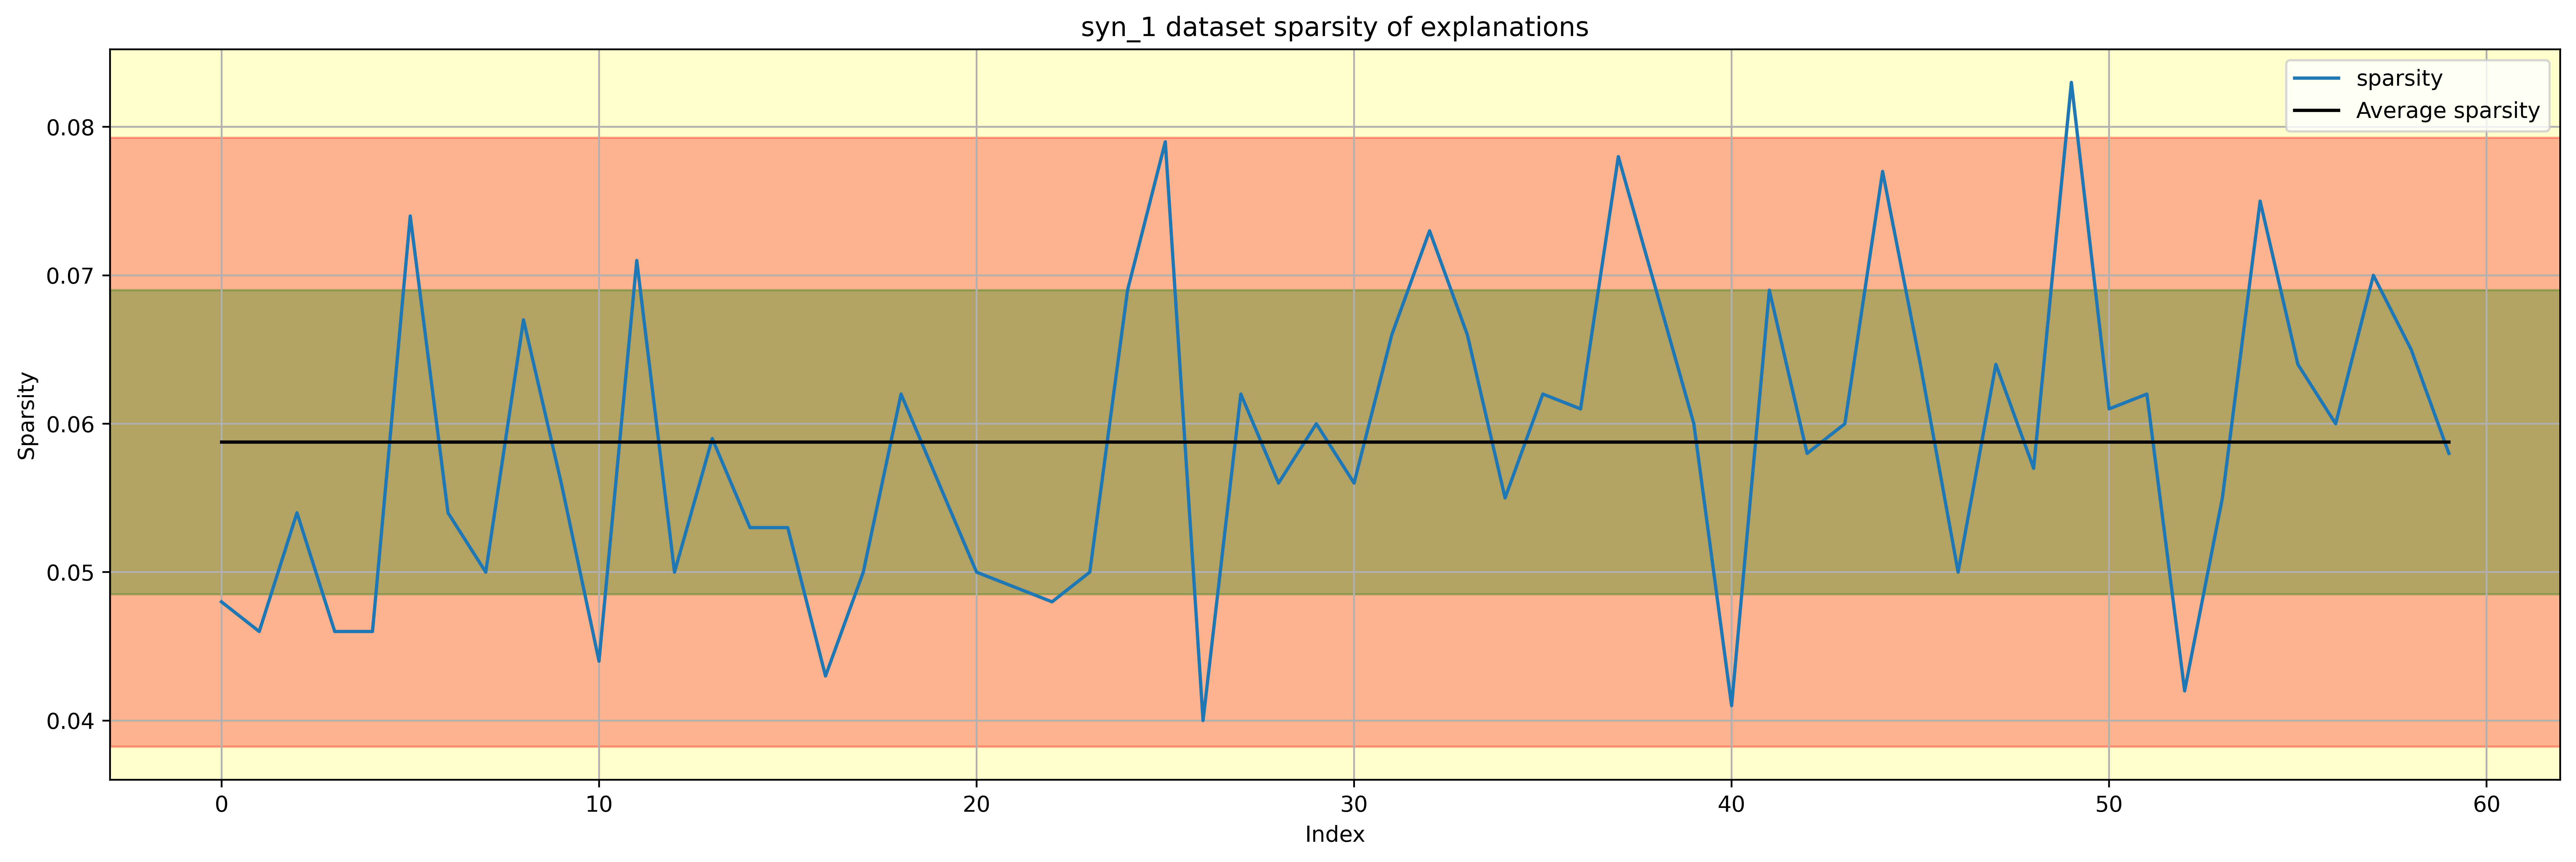

In [21]:
# Plot Sparsity
x = list(range(len(df1)))
sparse = list(df1['Sparsity'])
def_sparse = list(np.ones(len(df1))*0.5)
mean_sparse = list(np.ones(len(df1))*df1['Sparsity'].mean())
plt.figure(figsize=(20,6), dpi = 500)
plt.gca().grid(True)
plt.gca().set_facecolor((1, 1, 0.8))
plt.plot(x, sparse, label='sparsity')
# plt.plot(x,def_sparse, label = 'Max edge density for sparse graphs')
plt.plot(x,mean_sparse, label = 'Average sparsity', color='k')

sp_mean = df1['Sparsity'].mean()
sp_std = df1['Sparsity'].std()
y1 = sp_mean - sp_std
y_1 = y1 - sp_std
y2 = sp_mean + sp_std
y_2 = y2 + sp_std
plt.axhspan(y_1, y_2, color='red', alpha=0.3)
plt.axhspan(y1, y2, color='green', alpha=0.3)

plt.title('syn_1 dataset sparsity of explanations', fontsize=12)
plt.legend(prop={'size':10})
plt.ylabel("Sparsity")
plt.xlabel("Index")
plt.savefig(fname= "D:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\PGM_Node\Explain_GNN\plots\syn1_sparsity")
plt.show()